In [1]:
#!pip install pandas
#!pip install matplotlib
#!python -m pip install tensorflow
#!pip install nvidia-tensorrt
#!pip install sagemaker

In [2]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

2023-02-19 19:56:21.809332: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-19 19:56:21.810639: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-19 19:56:21.810648: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [3]:
sampling_rate=100

# Get the size of each sample
input_size = (1000,12,1)

In [4]:
# Train
X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')
# Test
X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')

In [5]:
X_train_norm_1 = (X_train - np.min(X_train))/np.ptp(X_train) # [0, 1]
X_train_norm_2 = 2.*(X_train - np.min(X_train))/np.ptp(X_train)-1 # [-1,1]

In [6]:
inputs = keras.Input(shape=input_size)

In [7]:
x = keras.layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same')(inputs)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('tanh')(x)

In [8]:
def conv_block(input_tensor, filters, strides):
    x = keras.layers.Conv2D(filters, (1, 1), strides=strides)(input_tensor)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('tanh')(x)

    x = keras.layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('tanh')(x)

    x = keras.layers.Conv2D(4 * filters, (1, 1))(x)
    x = keras.layers.BatchNormalization()(x)

    shortcut = keras.layers.Conv2D(4 * filters, (1, 1), strides=strides)(input_tensor)
    shortcut = keras.layers.BatchNormalization()(shortcut)

    x = keras.layers.add([x, shortcut])
    x = keras.layers.Activation('tanh')(x)
    return x

def identity_block(input_tensor, filters):
    x = keras.layers.Conv2D(filters, (1, 1))(input_tensor)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('tanh')(x)

    x = keras.layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('tanh')(x)

    x = keras.layers.Conv2D(4 * filters, (1, 1))(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.add([x, input_tensor])
    x = keras.layers.Activation('tanh')(x)
    return x


x = conv_block(x, 64, strides=(1, 1))
x = identity_block(x, 64)
x = identity_block(x, 64)

x = conv_block(x, 128, strides=(2, 2))
x = identity_block(x, 128)
x = identity_block(x, 128)
x = identity_block(x, 128)

x = conv_block(x, 256, strides=(2, 2))
x = identity_block(x, 256)
x = identity_block(x, 256)
x = identity_block(x, 256)
x = identity_block(x, 256)
x = identity_block(x, 256)

x = conv_block(x, 512, strides=(2,2))
x = identity_block(x, 512)
x = identity_block(x, 512)

x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(5, activation='sigmoid')(x)

In [9]:
model = keras.Model(inputs=inputs, outputs=x, name='resnet')
model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
history = model.fit(x=X_train_norm_2, y=y_train,
                    batch_size=32,
                    epochs=60, validation_split=0.2)

Epoch 1/60
491/491 [==============================] - 212s 370ms/step - loss: 0.6658 - accuracy: 0.3772 - val_loss: 0.7162 - val_accuracy: 0.0893
Epoch 2/60
491/491 [==============================] - 187s 381ms/step - loss: 0.6266 - accuracy: 0.4787 - val_loss: 0.6232 - val_accuracy: 0.4902
Epoch 3/60
491/491 [==============================] - 190s 388ms/step - loss: 0.6027 - accuracy: 0.5131 - val_loss: 0.5940 - val_accuracy: 0.5203
Epoch 4/60
491/491 [==============================] - 192s 391ms/step - loss: 0.5829 - accuracy: 0.5415 - val_loss: 0.5863 - val_accuracy: 0.5259
Epoch 5/60
491/491 [==============================] - 192s 391ms/step - loss: 0.5691 - accuracy: 0.5532 - val_loss: 0.6003 - val_accuracy: 0.5200
Epoch 6/60
491/491 [==============================] - 191s 389ms/step - loss: 0.5566 - accuracy: 0.5675 - val_loss: 0.5760 - val_accuracy: 0.5402
Epoch 7/60
491/491 [==============================] - 192s 391ms/step - loss: 0.5448 - accuracy: 0.5797 - val_loss: 0.5481 -

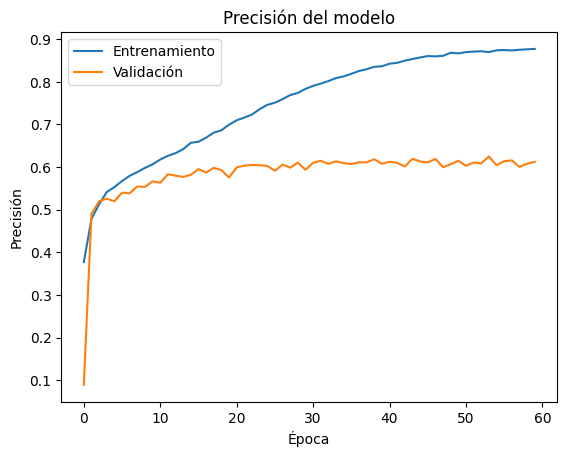

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precisión del modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')
plt.show()

In [12]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
X_test_norm = 2.*(X_test - np.min(X_train))/np.ptp(X_train)-1 # [-1,1]
results = model.evaluate(X_test_norm, y_test)
print("test loss, test acc:", results)

Evaluate on test data
69/69 [==============================] - 9s 125ms/step - loss: 0.5121 - accuracy: 0.5946
test loss, test acc: [0.5120893716812134, 0.5946314930915833]


In [13]:
model.save("resnet_model")

INFO:tensorflow:Assets written to: resnet_model/assets


INFO:tensorflow:Assets written to: resnet_model/assets
